In [2]:
import os
import pandas as pd
import sys
import numpy as np
from copy import deepcopy
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.utils import pad_sequences
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import nltk
import re
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
TreebankWordDetokenizer().detokenize
tokenizer1= nltk.RegexpTokenizer(r"\w+",)
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 70
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:

def tweet_clean(tweet):
  #convert tweet to tokens
  tweet=re.sub(r'http\S+', '', tweet, flags=re.MULTILINE)
  tokens = tokenizer1.tokenize(tweet)
  lowercased_tokens = [word.lower() for word in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in lowercased_tokens ]
  new_tweet=TreebankWordDetokenizer().detokenize(lemmatized_tokens)
  return new_tweet
  
texts = [] # list of text samples
labels_index = {} # dictionary mapping label name to numeric id
labels = [] # list of label ids
dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/file.csv')
X = []
labels_index = {
    "bad":0,
    "neutral":1,
    "good":2,
}
Y= []
for label in dataset['labels']:
  Y.append(labels_index[label])
for message in dataset['tweets']:
    X.append(tweet_clean(message))
labels_matrix = to_categorical(np.asarray(Y))

print('Found %s texts.' % len(X))
print('nLabels = ', len(Y))
print('Classes are:\n ')
for key, ID in labels_index.items():
 print (key,ID)


Found 219294 texts.
nLabels =  219294
Classes are:
 
bad 0
neutral 1
good 2


In [7]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index  
print('Found %s unique tokens.' % len(word_index)) 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of samples:', data.shape)


Found 92779 unique tokens.
Shape of samples: (219294, 70)


In [8]:
SPLIT = 0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data_shuffled = data[indices]
labels_shuffled = labels_matrix[indices]
nb_validation_samples = int(SPLIT * data_shuffled.shape[0])
x_train = data_shuffled[:-nb_validation_samples]
y_train = labels_shuffled[:-nb_validation_samples]
x_test = data_shuffled[-nb_validation_samples:]
y_test = labels_shuffled[-nb_validation_samples:]
print('training data shape: ',x_train.shape)
print('testing data shape: ',x_test.shape)

training data shape:  (175436, 70)
testing data shape:  (43858, 70)


In [9]:
#get all embeddings from glove
embeddings = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt') as f:
 for line in f:
  values = line.split(sep=' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings[word] = coefs
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
 embedding_vector = embeddings.get(word)
 if embedding_vector is not None:
  embedding_matrix[i] = embedding_vector
print ('Shape of Embedding Matrix: ',embedding_matrix.shape)


Shape of Embedding Matrix:  (92780, 50)


In [10]:
#CNN model first trial

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
history_cnn=np.zeros(4)

model1_cnn = Sequential([])
model1_cnn.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model1_cnn.add(layers.Dropout(0.5))
model1_cnn.add(Conv1D(16,3, activation='relu'))
model1_cnn.add(MaxPooling1D())
model1_cnn.add(Conv1D(16,3, activation='relu'))
model1_cnn.add(MaxPooling1D())
model1_cnn.add(layers.Flatten())
model1_cnn.add(layers.Dense(128, activation='relu'))
model1_cnn.add(layers.Dropout(0.5))
model1_cnn.add(layers.Dense(3, activation='softmax'))

model1_cnn.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.0003),
 metrics=['acc'])
model1_cnn.fit(x_train, y_train, validation_data=(x_test, y_test),
 epochs=3, batch_size=128)

history_cnn[0]=model1_cnn.evaluate(x_test,y_test)[1]
model1_cnn.summary()
Y_predict= model1_cnn.predict(x_test)
Y_predict = [np.argmax(element) for element in Y_predict]
Y_test = [np.argmax(element) for element in y_test]
print(classification_report(Y_test, Y_predict))  

Epoch 1/3
1371/1371 [==============================] - 75s 46ms/step - loss: 0.9704 - acc: 0.5391 - val_loss: 0.8550 - val_acc: 0.6148
Epoch 2/3
1371/1371 [==============================] - 14s 11ms/step - loss: 0.8114 - acc: 0.6295 - val_loss: 0.6283 - val_acc: 0.7320
Epoch 3/3
1371/1371 [==============================] - 4s 3ms/step - loss: 0.5267 - acc: 0.7981
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 50)            4639000   
                                                                 
 dropout (Dropout)           (None, 70, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 68, 16)            2416      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 34, 16)           0         
 )                

In [11]:
#CNN model second trial

model2_cnn = Sequential([])
model2_cnn.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model2_cnn.add(layers.Dropout(0.5))
model2_cnn.add(Conv1D(16,3, activation='relu'))
model2_cnn.add(MaxPooling1D())
model2_cnn.add(Conv1D(16,3, activation='relu'))
model2_cnn.add(MaxPooling1D())
model2_cnn.add(layers.Flatten())
model2_cnn.add(layers.Dense(128, activation='relu'))
model2_cnn.add(layers.Dropout(0.5))
model2_cnn.add(layers.Dense(3, activation='softmax'))

model2_cnn.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.001),
 metrics=['acc'])

model2_cnn.fit(x_train, y_train, validation_data=(x_test, y_test),
 epochs=3, batch_size=256)

history_cnn[1]=model2_cnn.evaluate(x_test,y_test)[1]

model2_cnn.summary()
Y_predict= model2_cnn.predict(x_test)
Y_predict = [np.argmax(element) for element in Y_predict]
Y_test = [np.argmax(element) for element in y_test]
print(classification_report(Y_test, Y_predict))  
         
          


Epoch 1/3
686/686 [==============================] - 67s 90ms/step - loss: 0.8660 - acc: 0.5966 - val_loss: 0.5801 - val_acc: 0.7599
Epoch 2/3
686/686 [==============================] - 13s 19ms/step - loss: 0.5984 - acc: 0.7481 - val_loss: 0.4301 - val_acc: 0.8411
Epoch 3/3
1371/1371 [==============================] - 5s 3ms/step - loss: 0.3496 - acc: 0.8774
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 50)            4639000   
                                                                 
 dropout_2 (Dropout)         (None, 70, 50)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 68, 16)            2416      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 34, 16)           0         
 1D)                  

In [12]:
#CNN model third trial

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

model3_cnn = Sequential([])
model3_cnn.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model3_cnn.add(layers.Dropout(0.5))
model3_cnn.add(Conv1D(16,3, activation='relu'))
model3_cnn.add(MaxPooling1D())
model3_cnn.add(layers.Flatten())
model3_cnn.add(layers.Dense(128, activation='relu'))
model3_cnn.add(layers.Dropout(0.5))
model3_cnn.add(layers.Dense(3, activation='softmax'))

model3_cnn.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.01),
 metrics=['acc'])
model3_cnn.fit(x_train, y_train, validation_data=(x_test, y_test),
 epochs=3, batch_size=128)

history_cnn[2]=model3_cnn.evaluate(x_test,y_test)[1]
model3_cnn.summary()
Y_predict= model3_cnn.predict(x_test)
Y_predict = [np.argmax(element) for element in Y_predict]
Y_test = [np.argmax(element) for element in y_test]
print(classification_report(Y_test, Y_predict))  

Epoch 1/3
1371/1371 [==============================] - 51s 35ms/step - loss: 0.5747 - acc: 0.7612 - val_loss: 0.3261 - val_acc: 0.8901
Epoch 2/3
1371/1371 [==============================] - 13s 10ms/step - loss: 0.3785 - acc: 0.8635 - val_loss: 0.3062 - val_acc: 0.8920
Epoch 3/3
1371/1371 [==============================] - 4s 3ms/step - loss: 0.2914 - acc: 0.9037
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 50)            4639000   
                                                                 
 dropout_4 (Dropout)         (None, 70, 50)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 68, 16)            2416      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 34, 16)           0         
 1D)              

In [27]:
#CNN model fourth trial


model4_cnn = Sequential([])
model4_cnn.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model4_cnn.add(layers.Dropout(0.5))
model4_cnn.add(Conv1D(16,3, activation='relu'))
model4_cnn.add(MaxPooling1D())
model4_cnn.add(layers.Flatten())
model4_cnn.add(layers.Dense(128, activation='relu'))
model4_cnn.add(layers.Dropout(0.5))
model4_cnn.add(layers.Dense(3, activation='softmax'))

model4_cnn.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.0003),
 metrics=['acc'])
model4_cnn.fit(x_train, y_train, validation_data=(x_test, y_test),
 epochs=4, batch_size=128)

history_cnn[3]=model4_cnn.evaluate(x_test,y_test)[1]
model1_cnn.summary()
Y_predict= model4_cnn.predict(x_test)
Y_predict = [np.argmax(element) for element in Y_predict]
Y_test = [np.argmax(element) for element in y_test]
print(classification_report(Y_test, Y_predict))  

Epoch 1/4
1371/1371 [==============================] - 48s 34ms/step - loss: 0.9611 - acc: 0.5437 - val_loss: 0.8183 - val_acc: 0.6254
Epoch 2/4
1371/1371 [==============================] - 13s 10ms/step - loss: 0.7858 - acc: 0.6406 - val_loss: 0.6102 - val_acc: 0.7404
Epoch 3/4
1371/1371 [==============================] - 11s 8ms/step - loss: 0.6616 - acc: 0.7117 - val_loss: 0.5103 - val_acc: 0.8006
Epoch 4/4
1371/1371 [==============================] - 4s 3ms/step - loss: 0.4559 - acc: 0.8279
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 50)            4639000   
                                                                 
 dropout (Dropout)           (None, 70, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 68, 16)            2416      
                

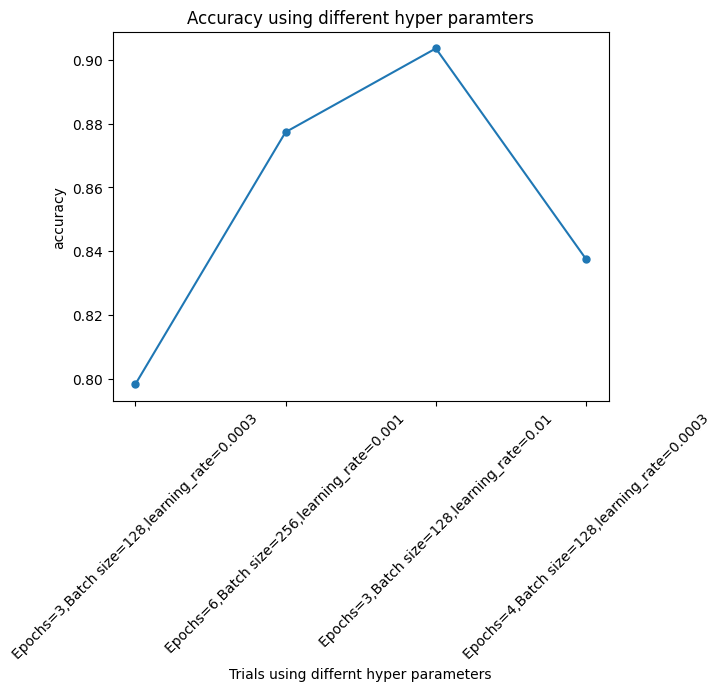

In [14]:
#Graph for Trials using differnt hyper parameters

import matplotlib.pyplot as plt
fig = plt.figure()

cnn = []
cnn.append('Epochs=3,Batch size=128,learning_rate=0.0003')
cnn.append('Epochs=6,Batch size=256,learning_rate=0.001')
cnn.append('Epochs=3,Batch size=128,learning_rate=0.01')
cnn.append('Epochs=4,Batch size=128,learning_rate=0.0003')


plt.xticks(rotation = 45)

plt.title("Accuracy using different hyper paramters")
plt.xlabel("Trials using differnt hyper parameters")
plt.ylabel("accuracy")
plt.plot(cnn,history_cnn,label="CNN model",marker='o',ms=5)



In [16]:
from sklearn.metrics import classification_report

#LSTM model first trial
history_lstm=np.zeros(4)

model1_lstm = Sequential([])
model1_lstm.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model1_lstm.add(layers.LSTM(64, return_sequences=True))
model1_lstm.add(layers.Dropout(0.2))
model1_lstm.add(layers.Flatten())
model1_lstm.add(layers.Dense(128, activation='relu'))
model1_lstm.add(layers.Dropout(0.5))
model1_lstm.add(layers.Dense(3, activation='softmax'))

model1_lstm.compile(loss='categorical_crossentropy',
 optimizer='rmsprop',
 metrics=['acc'])


model1_lstm.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=3, batch_size=64)

print('Acuracy on testing set:')
history_lstm[0]=model1_lstm.evaluate(x_test,y_test)[1]

model1_lstm.summary()
Y_predict2= model1_lstm.predict(x_test)
Y_predict2 = [np.argmax(element) for element in Y_predict2]
Y_test2 = [np.argmax(element) for element in y_test]
print(classification_report(Y_test2, Y_predict2)) 

Epoch 1/3
2742/2742 [==============================] - 65s 22ms/step - loss: 0.5679 - acc: 0.7659 - val_loss: 0.5129 - val_acc: 0.8032
Epoch 2/3
2742/2742 [==============================] - 24s 9ms/step - loss: 0.3444 - acc: 0.8749 - val_loss: 0.3102 - val_acc: 0.8896
Epoch 3/3
2742/2742 [==============================] - 23s 8ms/step - loss: 0.2846 - acc: 0.8995 - val_loss: 0.2933 - val_acc: 0.8949
Acuracy on testing set:
1371/1371 [==============================] - 6s 4ms/step - loss: 0.2933 - acc: 0.8949
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 70, 50)            4639000   
                                                                 
 lstm (LSTM)                 (None, 70, 64)            29440     
                                                                 
 dropout_8 (Dropout)         (None, 70, 64)            0         
   

In [17]:
 #LSTM model second trial
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

model2_lstm = Sequential([])
model2_lstm.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model2_lstm.add(layers.LSTM(32, return_sequences=True))
model2_lstm.add(layers.Flatten())

model2_lstm.add(layers.Dense(3, activation='softmax'))


model2_lstm.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.001),
 metrics=['acc'])


model2_lstm.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=3, batch_size=248)

print('Acuracy on testing set:')
history_lstm[1]=model2_lstm.evaluate(x_test,y_test)[1]


model2_lstm.summary()
Y_predict2= model2_lstm.predict(x_test)
Y_predict2 = [np.argmax(element) for element in Y_predict2]
Y_test2 = [np.argmax(element) for element in y_test]
print(classification_report(Y_test2, Y_predict2))  


Epoch 1/3
708/708 [==============================] - 50s 65ms/step - loss: 0.5918 - acc: 0.7525 - val_loss: 0.3726 - val_acc: 0.8670
Epoch 2/3
708/708 [==============================] - 12s 17ms/step - loss: 0.2994 - acc: 0.8971 - val_loss: 0.2853 - val_acc: 0.9017
Epoch 3/3
708/708 [==============================] - 10s 14ms/step - loss: 0.2328 - acc: 0.9233 - val_loss: 0.2639 - val_acc: 0.9108
Acuracy on testing set:
1371/1371 [==============================] - 5s 4ms/step - loss: 0.2639 - acc: 0.9108
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 70, 50)            4639000   
                                                                 
 lstm_1 (LSTM)               (None, 70, 32)            10624     
                                                                 
 flatten_5 (Flatten)         (None, 2240)              0         
       

In [18]:
 #LSTM model third trial

model3_lstm = Sequential([])
model3_lstm.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model3_lstm.add(layers.LSTM(64, return_sequences=True))
model3_lstm.add(layers.Dropout(0.2))
model3_lstm.add(layers.Flatten())
model3_lstm.add(layers.Dense(128, activation='relu'))
model3_lstm.add(layers.Dropout(0.5))
model3_lstm.add(layers.Dense(3, activation='softmax'))


model3_lstm.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.01),
 metrics=['acc'])


model3_lstm.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=4, batch_size=128)

print('Acuracy on testing set:')
history_lstm[2]=model3_lstm.evaluate(x_test,y_test)[1]


model3_lstm.summary()
Y_predict2= model3_lstm.predict(x_test)
Y_predict2 = [np.argmax(element) for element in Y_predict2]
Y_test2 = [np.argmax(element) for element in y_test]
print(classification_report(Y_test2, Y_predict2))  

Epoch 1/4
1371/1371 [==============================] - 57s 38ms/step - loss: 0.3917 - acc: 0.8510 - val_loss: 0.2499 - val_acc: 0.9090
Epoch 2/4
1371/1371 [==============================] - 18s 13ms/step - loss: 0.2599 - acc: 0.9060 - val_loss: 0.2498 - val_acc: 0.9110
Epoch 3/4
1371/1371 [==============================] - 15s 11ms/step - loss: 0.2273 - acc: 0.9176 - val_loss: 0.2441 - val_acc: 0.9108
Epoch 4/4
1371/1371 [==============================] - 13s 10ms/step - loss: 0.2078 - acc: 0.9249 - val_loss: 0.2604 - val_acc: 0.9068
Acuracy on testing set:
1371/1371 [==============================] - 7s 5ms/step - loss: 0.2604 - acc: 0.9068
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 70, 50)            4639000   
                                                                 
 lstm_2 (LSTM)               (None, 70, 64)            29440    

In [19]:
 #LSTM model fourth trial

model4_lstm = Sequential([])
model4_lstm.add(Embedding(len(word_index) + 1,
 50, 
 weights=[embedding_matrix], 
 input_length=MAX_SEQUENCE_LENGTH,) )
model4_lstm.add(layers.LSTM(64, return_sequences=True))
model4_lstm.add(layers.Flatten())
model4_lstm.add(layers.Dropout(0.5))
model4_lstm.add(layers.Dense(3, activation='softmax'))


model4_lstm.compile(loss='categorical_crossentropy',
 optimizer=Adam(learning_rate=0.003),
 metrics=['acc'])


model4_lstm.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=3, batch_size=128)

print('Acuracy on testing set:')
history_lstm[3]=model4_lstm.evaluate(x_test,y_test)[1]


model4_lstm.summary()
Y_predict2= model4_lstm.predict(x_test)
Y_predict2 = [np.argmax(element) for element in Y_predict2]
Y_test2 = [np.argmax(element) for element in y_test]
print(classification_report(Y_test2, Y_predict2)) 

Epoch 1/3
1371/1371 [==============================] - 59s 40ms/step - loss: 0.4115 - acc: 0.8414 - val_loss: 0.2591 - val_acc: 0.9094
Epoch 2/3
1371/1371 [==============================] - 16s 12ms/step - loss: 0.2271 - acc: 0.9193 - val_loss: 0.2172 - val_acc: 0.9234
Epoch 3/3
1371/1371 [==============================] - 15s 11ms/step - loss: 0.1831 - acc: 0.9351 - val_loss: 0.2150 - val_acc: 0.9223
Acuracy on testing set:
1371/1371 [==============================] - 6s 4ms/step - loss: 0.2150 - acc: 0.9223
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 70, 50)            4639000   
                                                                 
 lstm_3 (LSTM)               (None, 70, 64)            29440     
                                                                 
 flatten_7 (Flatten)         (None, 4480)              0         
 

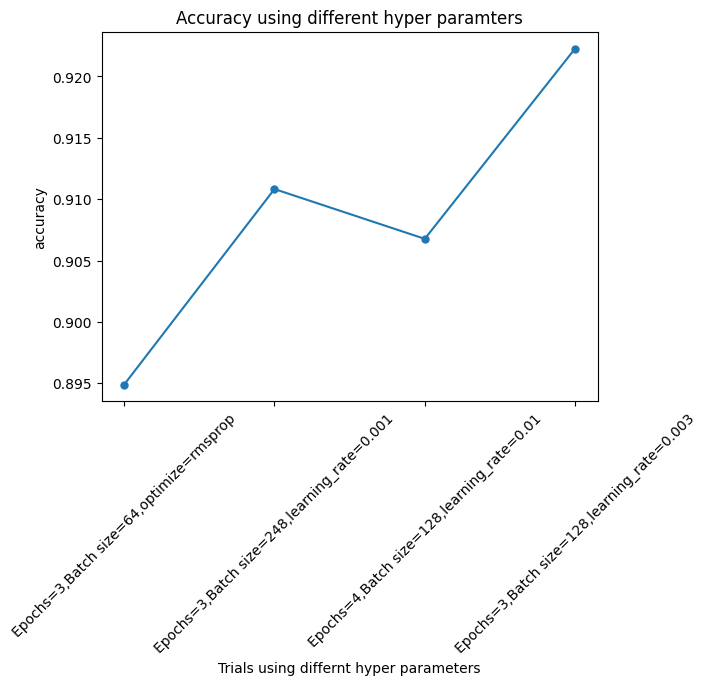

In [22]:
#Graph for Trials using differnt hyper parameters

import matplotlib.pyplot as plt
fig = plt.figure()

lstm = []

lstm.append('Epochs=3,Batch size=64,optimize=rmsprop')
lstm.append('Epochs=3,Batch size=248,learning_rate=0.001')
lstm.append('Epochs=4,Batch size=128,learning_rate=0.01')
lstm.append('Epochs=3,Batch size=128,learning_rate=0.003')

plt.xticks(rotation = 45)

plt.title("Accuracy using different hyper paramters")
plt.xlabel("Trials using differnt hyper parameters")
plt.ylabel("accuracy")

plt.plot(lstm,history_lstm,label="LSTM model",marker='o',ms=5)


In [26]:
#Input a new tweet  predicting using models
output_name = ''
sample = input("Enter your comment : ") 
tweet=tweet_clean(sample)
tweet_row=[tweet]
sequence_input=tokenizer.texts_to_sequences(tweet_row)
data_input=pad_sequences(sequence_input,maxlen=MAX_SEQUENCE_LENGTH)
label_vec = model3_cnn.predict(data_input[0].reshape(1,-1)) #can try different models
label_id = np.argmax(label_vec)
for name, ID in labels_index.items():
  if label_id == ID:
   output_name = name
   break
print("The tweet seems to be :  "+output_name)

Enter your comment : I sometimes hate chatgpt and sometimes love it
1/1 [==============================] - 0s 19ms/step
The tweet seems to be :  neutral
